## Tutoriel : interagir avec le système de stockage S3 du SSP Cloud (MinIO)

In [17]:
import os

import pandas as pd
import s3fs
import zipfile

### Récupérer les données d'un challenge

In [18]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [19]:
# Lister les challenges
fs.ls("gvimont/diffusion/hackathon-minarm-2024")

['gvimont/diffusion/hackathon-minarm-2024/AIVSAI',
 'gvimont/diffusion/hackathon-minarm-2024/Acoustique',
 'gvimont/diffusion/hackathon-minarm-2024/Similarité']

In [20]:
# Lister les fichiers d'un challenge
fs.ls("gvimont/diffusion/hackathon-minarm-2024/Similarité")

['gvimont/diffusion/hackathon-minarm-2024/Similarité/.keep',
 'gvimont/diffusion/hackathon-minarm-2024/Similarité/stanford0-car-dataset-by-classes-folder.zip']

In [21]:
# Télécharger les données dans le service
PATH_IN = 'gvimont/diffusion/hackathon-minarm-2024/Similarité/stanford0-car-dataset-by-classes-folder.zip'
fs.download(PATH_IN, 'data/stanford0-car-dataset-by-classes-folder.zip')

[None]

In [22]:
# Décompresser les données
with zipfile.ZipFile("data/stanford0-car-dataset-by-classes-folder.zip","r") as zip_file:
    zip_file.extractall("data/")

NB : les données peuvent être également téléchargées directement si besoin, pour être utilisées hors du SSP CLoud.
Exemple pour le fichier ci-dessus (même format de lien pour les autres challenges) : 

http://minio.lab.sspcloud.fr/gvimont/diffusion/hackathon-minarm-2024/AIVSAI/HC3.zip

### Exporter des données

In [ ]:
import pandas as pd
df = pd.read.('./data/HC3/medicine.jsonl', lines=True)


In [10]:
import pandas as pd

df_train = pd.read_csv(r"./data/anno_train.csv", header=None)
df_test = pd.read_csv(r"./data/anno_test.csv", header=None)

# Ajouter des en-têtes au DataFrame
headers = ['Imagefile', 'Bounding_boxe1','Bounding_boxe2' ,'Bounding_boxe3','Bounding_boxe4','class number']
df_train.columns = headers
df_test.columns = headers



df_train.head()
#df_test


,Imagefile,Bounding_boxe1,Bounding_boxe2,Bounding_boxe3,Bounding_boxe4,class number
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106


In [11]:
df_train.isnull().sum()


Imagefile         0
Bounding_boxe1    0
Bounding_boxe2    0
Bounding_boxe3    0
Bounding_boxe4    0
class number      0
dtype: int64

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model

# Paramètres du modèle
input_shape = (224, 224, 3)  # Taille des images d'entrée
num_classes = 195  # Nombre de classes

# Modèle ResNet18
inputs = Input(shape=input_shape)

x = Conv2D(64, (7, 7), strides=(2, 2), activation='relu', padding='same')(inputs)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

# Bloc ResNet 1
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x_shortcut = x

x = Conv2D(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# Ajouter le raccourci
x = tf.keras.layers.add([x, x_shortcut])

# Blocs ResNet restants
for i in range(2):
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x_shortcut = x

    x = Conv2D(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    # Ajouter le raccourci
    x = tf.keras.layers.add([x, x_shortcut])

# Couche de sortie
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Modèle
model = Model(inputs=inputs, outputs=outputs)

# Compilation du modèle
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

# Charger le modèle ResNet18
model = load_model('model.h5')

# Charger l'image à expliquer
image = np.load('image.npy')

# Prédire la classe de l'image
prediction = model.predict(image[np.newaxis, ...])
predicted_class = np.argmax(prediction)

# Générer la carte Grad-CAM
with tf.GradientTape() as tape:
    tape.watch(image)
    outputs = model(image[np.newaxis, ...])
    output = outputs[:, predicted_class]

grads = tape.gradient(output, image)[0]
grads = np.reshape(grads, (image.shape[0], image.shape[1], 3))

# Normaliser la carte Grad-CAM
grads_norm = (grads - np.min(grads)) / (np.max(grads) - np.min(grads))

# Superposer la carte Grad-CAM sur l'image d'entrée
cam = np.repeat(grads_norm, 3, axis=2) * 0.5 + image * 0.5

# Afficher la carte Grad-CAM
import matplotlib.pyplot as plt
plt.imshow(cam)
plt.show()


In [ ]:
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer

# Assuming you have your loaded ResNet18 model (replace with your loading logic)
model = ...  # Your loaded ResNet18 model

# Assuming you have your preprocessed data as a pandas DataFrame (replace with yours)
data = pd.DataFrame(...)  # Your data with features and target variable

# Extract features and target variable from the DataFrame
features = data.drop('target_column_name', axis=1).columns.tolist()
target_variable = 'target_column_name'

# Create a LIME explainer for your data and features
explainer = LimeTabularExplainer(
    data=data[features].values,
    mode="classification",
    class_names=data[target_variable].unique(),
    feature_names=features
)

# Function to predict with your model (replace with your prediction logic)
def predict_fn(x):
    return model.predict(x)[0]

# Explanation example: get an explanation for a specific data point (replace with your index)
instance_index = 10  # Choose the data point index you want to explain
explanation = explainer.explain_instance(
    data.iloc[instance_index][features].values.reshape(1, -1),
    predict_fn,
    num_features=5  # Number of features to show in explanation
)

# Print the explanation
print(explanation.as_text())


In [4]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import PIL.Image as Image
from IPython.display import display

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)
#print(torch.cuda.get_device_name(device))

In [19]:
# Export vers un bucket personnel
PATH_OUT = 'avouacr/diffusion/projet-mongroupe-hackathon/medicine.csv'

with fs.open(PATH_OUT, 'w') as file_out:
    df.to_csv(file_out, index=False)

In [20]:
# NB : le dossier 'diffusion' permet un accès en lecture à tous les membres du groupe !
# Tous les membres peuvent donc le voir et l'utiliser dans un service
fs.ls("avouacr/diffusion/projet-mongroupe-hackathon")

['avouacr/diffusion/projet-mongroupe-hackathon/medicine.csv']

In [21]:
with fs.open(PATH_OUT, mode="r") as file_in:
    df_test = pd.read_csv(file_in)

In [22]:
df_test.head()

,question,human_answers,chatgpt_answers
0,Does Primolut N taken during pregnancy affect ...,"['Hi, Thanks for the query. I understand y...",['It is not recommended to use Primolut N duri...
1,Bloating and pain on right lower abdomen. Shou...,"['Hello,Thanks for the query to H.C.M. Forum.P...",['If you are experiencing abdominal pain and b...
2,Is chest pain related to intake of clindamycin...,"['Hello, The use of Clindamycin can cause stom...",['It is possible that chest pain could be rela...
3,Q. Noticed a yellowish sag in the gums of my 1...,['Hello. Revert back with the photos to a dent...,"[""It is difficult to accurately diagnose a con..."
4,"Suggest remedy for low grade fever, hot and co...","['Hi Dear,Welcome to Healthcaremagic Team.Unde...","[""I'm sorry to hear that you're feeling sick. ..."


Epoch 1/15, Loss: 4.9847, Acc: 0.0354
Test Acc: 0.1530
Epoch duration: 7m 46s
Epoch 2/15, Loss: 3.9516, Acc: 0.1374
Test Acc: 0.3156
Epoch duration: 10m 10s
Epoch 3/15, Loss: 3.2958, Acc: 0.2419
Test Acc: 0.4618
Epoch duration: 6m 52s
Epoch 4/15, Loss: 2.8759, Acc: 0.3258
Test Acc: 0.5377
Epoch duration: 5m 40s
Epoch 5/15, Loss: 2.5561, Acc: 0.3913
Test Acc: 0.6126
Epoch duration: 5m 50s
Epoch 6/15, Loss: 2.3714, Acc: 0.4271
Test Acc: 0.6534
Epoch duration: 5m 11s
Epoch 7/15, Loss: 2.1253, Acc: 0.4831
Test Acc: 0.6793
Epoch duration: 5m 45s
Epoch 8/15, Loss: 1.9872, Acc: 0.5098
Test Acc: 0.6967
Epoch duration: 5m 34s
Epoch 9/15, Loss: 1.8547, Acc: 0.5413
Test Acc: 0.7213
Epoch duration: 5m 29s
Epoch 10/15, Loss: 1.4764, Acc: 0.6429
Test Acc: 0.8035
Epoch duration: 5m 18s
Epoch 11/15, Loss: 1.3323, Acc: 0.6817
Test Acc: 0.8098
Epoch duration: 5m 40s
Epoch 12/15, Loss: 1.2818, Acc: 0.6992
Test Acc: 0.8197
Epoch duration: 5m 20s
Epoch 13/15, Loss: 1.2349, Acc: 0.7073
Test Acc: 0.8237
Epoc

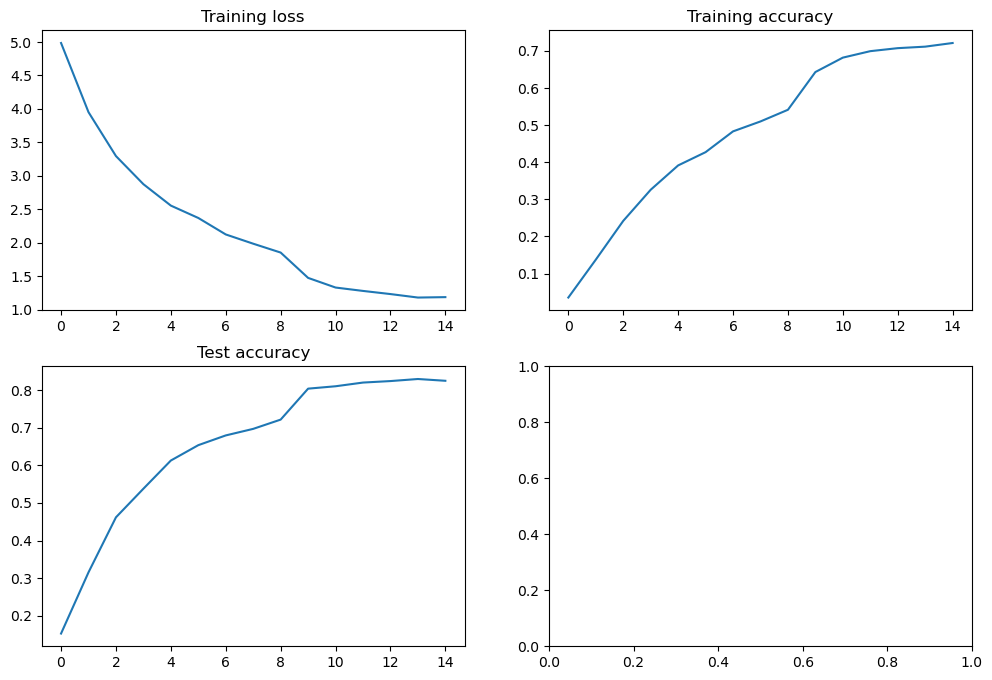

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import time
import torchvision
from torchvision import datasets, models, transforms

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, n_epochs=1):
    losses = []
    accuracies = []
    test_accuracies = []
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        model.eval()
        test_acc = eval_model(model, val_loader)
        test_accuracies.append(test_acc)

        model.train()
        scheduler.step(test_acc)
        time_elapsed = time.time() - since
        print(f"Epoch duration: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")

    print('Finished Training')
    return model, losses, accuracies, test_accuracies

def eval_model(model, val_loader):
    corrects = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
    acc = corrects.double() / total
    print(f'Test Acc: {acc:.4f}')
    return acc

if __name__ == '__main__':
    # Data transforms
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    # Load data
    data_dir = '/home/onyxia/work/6milarit-7/data/stanford-car-dataset-by-classes-folder/car_data/car_data'
    image_datasets = {x: datasets.ImageFolder(
                        root=data_dir + '/' + x,
                        transform=data_transforms[x])
                      for x in ['train', 'test']}

    # Create data loaders
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
                   for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

    # Initialize model
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 196)

    # Use GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold=0.9)

    # Train the model
    model, training_losses, training_accs, test_accs = train_model(model, criterion, optimizer, scheduler,
                                                                   dataloaders['train'], dataloaders['test'], n_epochs=15)

    # Save the trained model
    torch.save(model.state_dict(), "./trainedModelFinal.pt")

    # Plot results
    fig, axarr = plt.subplots(2, 2, figsize=(12, 8))
    axarr[0, 0].plot(training_losses)
    axarr[0, 0].set_title("Training loss")
    axarr[0, 1].plot(training_accs)
    axarr[0, 1].set_title("Training accuracy")
    axarr[1, 0].plot(test_accs)
    axarr[1, 0].set_title("Test accuracy")

    plt.show()
